# Translating Plate at 20°

In [1]:
using VortexModel

import VortexModel.Vortex
import Vortex.Sheets: arclength

## Set up plotting

The specifics of how we plot the figures are not important.  We will be using [`PyPlot`](https://github.com/JuliaPy/PyPlot.jl), but you can use any plotting package you like.

In [2]:
@static if isinteractive()
    using PyPlot
    function plot_system(sys)
        plate, (sheet₊, sheet₋) = sys
        plot(real.(plate.zs[[1,plate.N]]), imag.(plate.zs[[1,plate.N]]), "k")
        plot(real.(sheet₊.zs), imag.(sheet₊.zs), 
             linewidth = 1, color="#e41a1c")
        plot(real.(sheet₋.zs), imag.(sheet₋.zs), 
             linewidth = 1, color="#377eb8")
        axis(:scaled)
    end
else
    plot_system(sys) = nothing
end

plot_system (generic function with 1 method)

## Initialize plate and sheets

We are simulating a flat plate with zero thickness impulsively translating horizontally:

In [3]:
L = 2.0   # chord length
ċ = 0.5L  # translation velocity
α = π/9   # angle of attack

N = 128   # number of plate control points

Δt = 1e-2; # time step

We discretize the shear layers as vortex sheets, and assume that the Kutta condition is enforced at the trailing edge, and the suction parameter at the leading edge is kept below a critical value.

In [4]:
δ = 0.01
lesp = 0.1
tesp = 0.0

0.0

We place the initial segments of the vortex sheet perpendicular to the edges of the plate

In [5]:
plate = Vortex.Plate(N, L, zero(Complex128), α)
motion = Vortex.Plates.Motion(ċ, 0.0)

Δz₀ = im*Δt*exp(im*α)
z₋, z₊ = plate.zs[[1,N]]

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, 1.0], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, 1.0], δ)

Vortex.Plates.enforce_no_flow_through!(plate, motion, ())
Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux!(plate, sheet₊, sheet₋, lesp, tesp);

sheet₊ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₊, [0.0, Γ₊], δ)
sheet₋ = Vortex.Sheet([0.5, 1.5] .* Δz₀ + z₋, [0.0, Γ₋], δ)

ambient_sys = (sheet₊, sheet₋)
sys = (plate, ambient_sys)
ẋs = (motion, allocate_velocity(ambient_sys));

## Time Marching

At every time-step, before computing the self induced velocity of the system, we must first enforce the no-flow-through condition on the plate.  So the velocity function for time marching is:

In [6]:
function compute_ẋ!(ẋ, x, t)
    reset_velocity!(ẋ, x)
    self_induce_velocity!(ẋ, x)
end

compute_ẋ! (generic function with 1 method)

The centers of new vortex sheet segments are placed a third of the distance between the edges of the plate to last segment of sheet:

In [7]:
function shed_new_vorticity!(sheet₊, sheet₋, plate, motion, lesp = 0.0, tesp = 0.0)
    z₊ = (sheet₊.blobs[end].z + 2plate.zs[end])/3
    z₋ = (sheet₋.blobs[end].z + 2plate.zs[1])/3
    
    segment₊ = Vortex.Blob.([sheet₊.blobs[end].z, z₊], [0.5, 0.5], δ)
    segment₋ = Vortex.Blob.([sheet₋.blobs[end].z, z₋], [0.5, 0.5], δ)
    Vortex.Plates.enforce_no_flow_through!(plate, motion, (sheet₊, sheet₋))
    
    Γ₊, Γ₋, _, _ = Vortex.Plates.vorticity_flux!(plate, segment₊, segment₋, lesp, tesp);
    Vortex.Sheets.append_segment!(sheet₊, z₊, Γ₊)
    Vortex.Sheets.append_segment!(sheet₋, z₋, Γ₋)
end

shed_new_vorticity! (generic function with 3 methods)

After advecting the system, we apply filtering on both the leading and trailing edge vortex sheets, and use the [LESP criteria](https://doi.org/10.1017/jfm.2014.297) for leading edge vortex shedding and the Kutta condition for trailing edge vortex shedding:

In [8]:
for t in 0.0:Δt:9.0
    forward_euler!(sys, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    for sheet in sys[2]
        arclength(sheet) ≥ 3Δt && Vortex.Sheets.filter!(sheet, 2Δt, 6Δt)
    end
     
    shed_new_vorticity!(sheet₊, sheet₋, plate, motion, lesp, tesp)
end

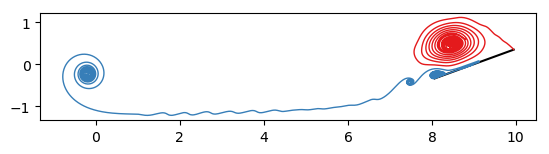

In [9]:
plot_system(sys);